In [9]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_train_data, get_test_data, get_X_y
from py_files.helper_funcs import set_np_pd_display_params, p
from py_files.features import generate_features
from config import data_path
from shapely.wkt import loads
import xgboost as xgb
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
from IPython.display import HTML
import json
from copy import deepcopy
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

set_np_pd_display_params(np, pd)

# random forest thing

In [5]:
# load the pickle models/rf_grid_search.pkl
with open('models/rf_grid_search.pkl', 'rb') as f:
    rf_grid_search = pickle.load(f)

best_params = rf_grid_search.best_params_
print(best_params)

{'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 200}


In [10]:
p("Getting the X and y")
X, y = get_X_y()
feature_X = generate_features(X, y)
feature_X = feature_X.drop(columns=['pickup_datetime'])
X_train, X_test, y_train, y_test = train_test_split(feature_X, y, test_size=0.2, random_state=42)
p()

p("Training the RandomForestRegressor")
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)
p()

p("Compute the RMSE")
y_pred = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred, squared=False)
p()

print(f'Random Forest RMSE: {rf_rmse}')


Getting the X and y...DONE 3.4 sec
Training the RandomForestRegressor...DONE 77.036 sec
Compute the RMSE...DONE 0.676 sec
Random Forest RMSE: 605.1684448745805


In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(feature_X, y)

plt.hist(y, bins=100, alpha=0.5)
plt.hist(y_resampled, bins=100, alpha=0.5)
plt.show()


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

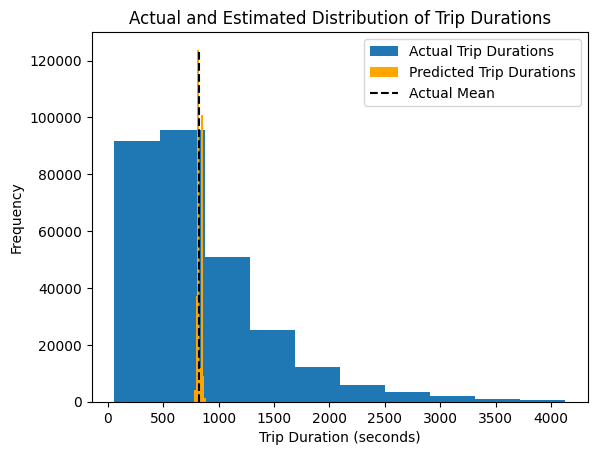

In [27]:
def plot_actual_vs_predicted_distributions(show=False):
    # plot a histogram of the actual trip duration distribution in the test set
    # and compute the mean
    counts, bins, patches = plt.hist(y_test, label='Actual Trip Durations')
    actual_mean = np.mean(y_test)

    # plot a histogram of the predicted trip duration distribution on the test set
    counts_pred, bins_pred, pathces_pred = plt.hist(y_pred, label='Predicted Trip Durations', color='orange')

    # plot a verticle line at the actual mean of the distribution
    top = max(np.max(counts), np.max(counts_pred))
    plt.vlines([actual_mean], 0, top, color='black', linestyles='dashed', label='Actual Mean')

    # set other plot parameters and show the plot
    plt.legend()
    plt.title("Actual and Estimated Distribution of Trip Durations")
    plt.xlabel("Trip Duration (seconds)")
    plt.ylabel("Frequency")
    plt.savefig('images/actual_vs_predicted.png')
    
    if show:
        plt.show()
    else:
        plt.clf()
    
plot_actual_vs_predicted_distributions(show=True)

### random forest thing

# hyperparameter tune a RandomForestRegressor

In [ ]:
X, y = get_X_y(force_clean=True)
feature_X = generate_features(X, y)

In [ ]:
X_train = feature_X.copy()
y_train = y.copy()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
'''
X_train = X_train.sample(100)
y_train = y_train.loc[X_train.index]'''

In [ ]:
df = pd.DataFrame({
    'A': [1,2,3,1,2,3,1,2,3,1,2,3,4,5],
    'B': np.arange(14),
    'C': np.arange(14)*10
}).sort_values(by=['A'])

df_copy = df.copy()
df = df_copy.copy()

dfs = []

for _ in range(3):
    firsts = df['A'] != df['A'].shift(1)
    dfs.append(df.loc[firsts].copy())
    df = df.loc[~firsts].copy()
    
display(df_copy)
display(pd.concat(dfs).sort_values(by=['A']))
    


In [ ]:
X_train = feature_X.copy()
y_train = y.copy()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

sample_per_class = 5
df = X_train.copy()
df = df.sort_values(by='avg_cluster_duration')
display(df['avg_cluster_duration'].value_counts())

dfs = []

for _ in range(4):
    firsts = df['avg_cluster_duration'] != df['avg_cluster_duration'].shift(1)
    dfs.append(df.loc[firsts].copy())
    df = df.loc[~firsts].copy()

final_df = pd.concat(dfs, axis=0).sort_values('avg_cluster_duration')
X_train = final_df.copy()
y_train = y_train.loc[X_train.index]

print(X_train.shape)
print(y_train.shape)

In [ ]:
display(X_train.sort_values(by='avg_cluster_duration').tail(50))
display(X_train[X_train['avg_cluster_duration'] == 845.2965812])
display(X_train['avg_cluster_duration'].value_counts())

In [ ]:
# Create a GridSearchCV object and get the optimal parameters and best score
param_grid = {
    'n_estimators': [100, 200, 400, 800, 1000],
    'max_depth': [None, 3, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5],
}


fits = np.product([len(param) for param in param_grid.values()]) * 4
print(fits)

rf = RandomForestRegressor(warm_start=False)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=3, n_jobs=-2, cv=4).fit(X_train, y_train)

with open("models/rf_grid_search.pkl", "wb") as f:
    pickle.dump(grid_search, f)

In [ ]:
64/3

In [ ]:
(10*60) * (4)

In [ ]:
with open("models/rf_grid_search.pkl", "rb") as f:
    grid_search = pickle.load(f)

best_params = grid_search.best_params_

rf = RandomForestRegressor(**best_params, warm_start=False)
rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))

# print the number of leaf nodes
print(rf.get_params())

### end hyperparameter RandomForestRegressor

# test avg cluster duration feature

In [ ]:
X, y = get_X_y(force_clean=True)
feature_X = generate_features(X, y)
display(feature_X)

In [ ]:
print(feature_X['vendor_id'].unique())

# load NYC roads as geopandas

In [ ]:
X, y = get_X_y()

In [ ]:
nyc_df = pd.read_csv(f"{data_path}/Centerline.csv")
nyc_df = nyc_df.loc[:, ['the_geom']]

# Convert the "the_geom" column to Shapely geometries
nyc_df['the_geom_geopandas'] = nyc_df['the_geom'].apply(loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(nyc_df, geometry='the_geom_geopandas')

min_lon, min_lat, max_lon, max_lat = gdf['the_geom_geopandas'].total_bounds

In [ ]:
code_str = """
nyc_df = pd.read_csv(f"{data_path}/Centerline.csv")
nyc_df = nyc_df.loc[:, ['the_geom']]

# Convert the "the_geom" column to Shapely geometries
nyc_df['the_geom_geopandas'] = nyc_df['the_geom'].apply(loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(nyc_df, geometry='the_geom_geopandas')

min_lon, min_lat, max_lon, max_lat = gdf['the_geom_geopandas'].total_bounds
"""

with open("misc/lat_long_bounds.json", "w+") as file:
    lat_lon_min_max = {
        'lat': {
            'min': min_lat,
            'max': max_lat
        },
        'lon': {
            'min': min_lon,
            'max': max_lon
        },
        'code_str': code_str
    }
    json.dump(lat_lon_min_max, file, indent=2)

In [ ]:
X_small = X.loc[(X['pickup_longitude'] >= min_lon) & (X['pickup_longitude'] <= max_lon) &
            (X['pickup_latitude'] >= min_lat) & (X['pickup_latitude'] <= max_lat), :].copy()
X_small = X_small.loc[(X_small['dropoff_longitude'] >= min_lon) & (X_small['dropoff_longitude'] <= max_lon) &
            (X_small['dropoff_latitude'] >= min_lat) & (X_small['dropoff_latitude'] <= max_lat), :].copy()

In [ ]:
print(X_small.shape)
print(X.shape)
display(X_small.head())
display(X.head())

In [ ]:
# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

alpha = 0.75

plt.scatter(X_small['pickup_longitude'], X_small['pickup_latitude'], c='red', alpha=alpha, s=0.1, label="Pickup Locations")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Pickup Locations")
plt.show()


# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(X_small['dropoff_longitude'], X_small['dropoff_latitude'], c='green', alpha=alpha, s=0.1, label="Dropoff Locations")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Dropoff Locations")
plt.show()

In [ ]:
# use sklearn kmeans to cluster the pickup and dropoff locations into 100 clusters
from sklearn.cluster import KMeans

n_clusters = 200

kmeans_pickup = KMeans(n_clusters=n_clusters, random_state=42).fit(X_small.loc[:, ['pickup_longitude', 'pickup_latitude']].values)
kmeans_dropoff = KMeans(n_clusters=n_clusters, random_state=42).fit(X_small.loc[:, ['dropoff_longitude', 'dropoff_latitude']].values)

pickup_centers = kmeans_pickup.cluster_centers_
dropoff_centers = kmeans_dropoff.cluster_centers_

X_small['pickup_cluster'] = kmeans_pickup.predict(X_small[['pickup_longitude', 'pickup_latitude']].values)
X_small['dropoff_cluster'] = kmeans_dropoff.predict(X_small[['dropoff_longitude', 'dropoff_latitude']].values)

In [ ]:
# save the kmeans_pickup and kmeans_dropoff in the models folder using pickle
import pickle

with open("models/kmeans_200_pickup.pkl", "wb+") as file:
    pickle.dump(kmeans_pickup, file)
    
with open("models/kmeans_200_dropoff.pkl", "wb+") as file:
    pickle.dump(kmeans_dropoff, file)

In [ ]:
# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(X_small['pickup_longitude'], X_small['pickup_latitude'], c=X_small['pickup_cluster'], cmap='magma', alpha=1.0, s=0.1, label="Pickup Locations")
plt.scatter(pickup_centers[:, 0], pickup_centers[:, 1], c='red', alpha=1, s=10, label="Cluster Centers")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("100-KMeans Clustering for Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(X_small['dropoff_longitude'], X_small['dropoff_latitude'], c=X_small['dropoff_cluster'], cmap='viridis', alpha=1.0, s=0.1, label="Dropoff Locations")
plt.scatter(dropoff_centers[:, 0], dropoff_centers[:, 1], c='blue', alpha=1, s=10, label="Cluster Centers")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("100-KMeans Clustering for Dropoff Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# creating the cluster distance feature

In [28]:
from py_files.data_manager import get_X_y, get_nyc_gdf
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
from sklearn.cluster import KMeans
import numpy as np
from matplotlib.collections import LineCollection

from py_files.helper_funcs import set_np_pd_display_params

set_np_pd_display_params(np, pd)

In [29]:
X, y = get_X_y()
X = generate_features(X, y)
full_df = pd.concat([X, y], axis=1)
nyc_gdf = get_nyc_gdf()
display(full_df.head())

/home/jeffx/ACME/senior/NYC_Taxi_Trip_Duration/py_files/data_manager.py:178: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv(f"{data_path}/Centerline.csv")


,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period_morning,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm,distance_km,temperature_2m (°C),precipitation (mm),cloudcover (%),avg_cluster_duration,trip_duration
0,1,2016-03-14 17:24:55,1,-73.9821548,40.7679367,-73.9646301,40.7656021,3,True,False,False,False,False,False,17,24,False,True,False,-0.9659258,-0.2588190,0.4050858,2.2082550,6.4000000,0.2000000,100.0000000,793.3510638,455
1,1,2016-03-14 17:19:42,1,-73.9930954,40.7479172,-74.0063400,40.7344055,3,True,False,False,False,False,False,17,19,False,True,False,-0.9659258,-0.2588190,0.4050659,2.9751633,6.4000000,0.2000000,100.0000000,823.9855072,663
2,1,2016-03-14 16:57:39,5,-73.9795074,40.7853470,-73.9702682,40.7990913,3,True,False,False,False,False,False,16,57,False,True,False,-0.8660254,-0.5000000,0.4049818,2.5556543,6.4000000,0.2000000,100.0000000,824.1956989,2124
3,1,2016-03-14 17:01:41,1,-73.9842453,40.7490425,-73.9998932,40.7340736,3,True,False,False,False,False,False,17,1,False,True,False,-0.9659258,-0.2588190,0.4049972,3.4044284,6.4000000,0.2000000,100.0000000,781.1345029,429
4,1,2016-03-14 17:16:07,1,-74.0067596,40.7055588,-73.9805679,40.7875404,3,True,False,False,False,False,False,17,16,False,True,False,-0.9659258,-0.2588190,0.4050522,12.0283300,6.4000000,0.2000000,100.0000000,811.0000000,435


In [30]:
df = deepcopy(full_df)

In [32]:
# load kmeans_pickup and kmeans_dropoff from the models folder using pickle
with open("models/kmeans_200_pickup.pkl", "rb") as file:
    kmeans_200_pickup = pickle.load(file)
with open("models/kmeans_200_dropoff.pkl", "rb") as file:
    kmeans_200_dropoff = pickle.load(file)
    
# predict the clusters for the pickup and dropoff locations using the kmeans_pickup and kmeans_dropoff
df['pickup_200_cluster'] = kmeans_200_pickup.predict(df[['pickup_longitude', 'pickup_latitude']].values)
df['dropoff_200_cluster'] = kmeans_200_dropoff.predict(df[['dropoff_longitude', 'dropoff_latitude']].values)

# get the centers
pickup_200_centers = kmeans_200_pickup.cluster_centers_
dropoff_200_centers = kmeans_200_dropoff.cluster_centers_

# compute the average duration from cluster to cluster
group_durations = (df
    .groupby(['pickup_200_cluster', 'dropoff_200_cluster'])['trip_duration']
    .mean()
    .reset_index()
    .rename(columns={'trip_duration': 'avg_cluster_duration'}))

# merge the average duration from cluster to cluster with the main dataframe
df = pd.merge(
    left=df, right=group_durations, how='left',
    left_on=['pickup_200_cluster', 'dropoff_200_cluster'], right_on=['pickup_200_cluster', 'dropoff_200_cluster'])

# fill the missing values with the mean of the average duration from cluster to cluster
df['avg_cluster_duration'] = df['avg_cluster_duration'].fillna(df['avg_cluster_duration'].mean())
#df.drop(columns=['pickup_200_cluster', 'dropoff_200_cluster'], inplace=True)

display(df)

KeyError: 'avg_cluster_duration'

In [33]:
pickup_cluster_df = pd.DataFrame({
    'pickup_200_cluster': np.arange(0, 200),
    'pickup_longitude': pickup_200_centers[:, 0],
    'pickup_latitude': pickup_200_centers[:, 1]
})
dropoff_cluster_df = pd.DataFrame({
    'dropoff_200_cluster': np.arange(0, 200),
    'dropoff_longitude': dropoff_200_centers[:, 0],
    'dropoff_latitude': dropoff_200_centers[:, 1]
})

display(pickup_cluster_df.head())
display(dropoff_cluster_df.head())

,pickup_200_cluster,pickup_longitude,pickup_latitude
0,0,-74.0066713,40.7158940
1,1,-73.9643720,40.7731762
2,2,-73.7824125,40.6456335
3,3,-73.9944761,40.7513196
4,4,-73.8725073,40.7738938


,dropoff_200_cluster,dropoff_longitude,dropoff_latitude
0,0,-73.9515589,40.7718087
1,1,-73.9836752,40.7373086
2,2,-73.7766222,40.6727814
3,3,-74.0085072,40.7131050
4,4,-73.8719442,40.7739929


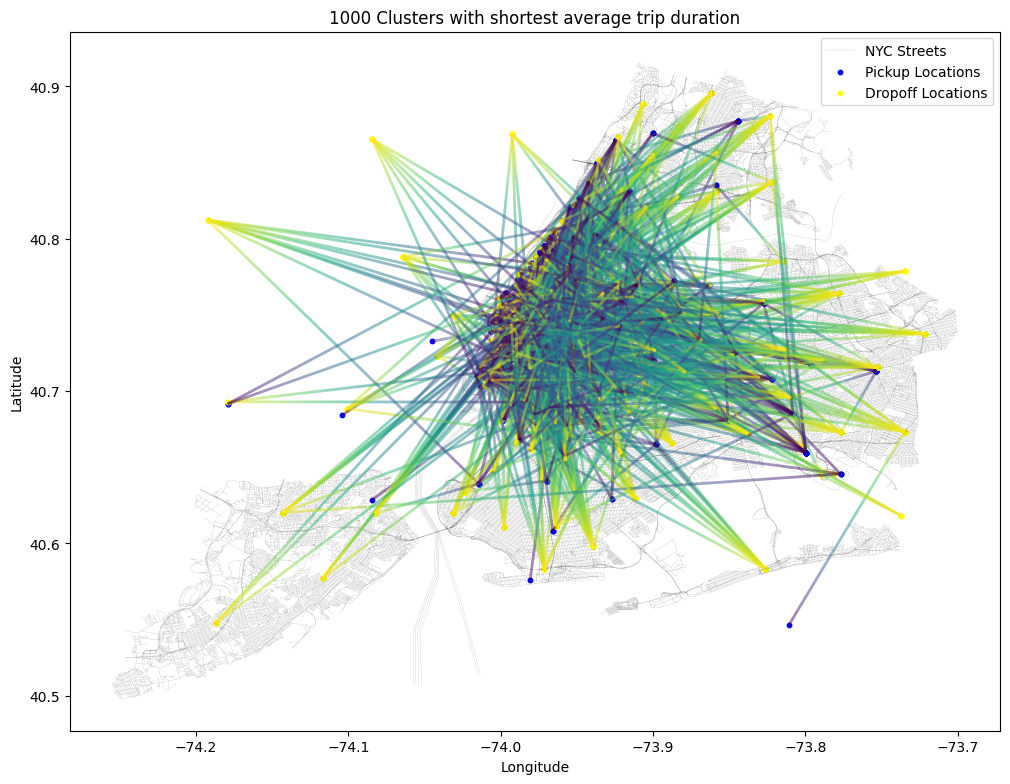

In [34]:
group_durations_sorted = group_durations.sort_values(by='avg_cluster_duration', ascending=False)
n = 1000
top_n = group_durations_sorted.iloc[-n:, :]

top_n = pd.merge(
    left=top_n, right=pickup_cluster_df, how='left',
    left_on=['pickup_200_cluster'], right_on=['pickup_200_cluster'])
top_n = pd.merge(
    left=top_n, right=dropoff_cluster_df, how='left',
    left_on=['dropoff_200_cluster'], right_on=['dropoff_200_cluster'])

pickup_longitudes = top_n['pickup_longitude'].values
pickup_latitudes = top_n['pickup_latitude'].values
dropoff_longitudes = top_n['dropoff_longitude'].values
dropoff_latitudes = top_n['dropoff_latitude'].values

# plot the GeoDataFrame
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

# plot the GeoDataFrame on the current ax
nyc_gdf.plot(ax=ax, linewidth=0.1, edgecolor='black', alpha=0.5, label="NYC Streets")

#nyc_gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(pickup_longitudes, pickup_latitudes, c='blue', alpha=1.0, s=10, label="Pickup Locations")
plt.scatter(dropoff_longitudes, dropoff_latitudes, c='yellow', alpha=1.0, s=10, label="Dropoff Locations")
    
for plong, plat, dlong, dlat in zip(pickup_longitudes, pickup_latitudes, dropoff_longitudes, dropoff_latitudes):
    x = np.linspace(plong, dlong, 100)
    y = np.linspace(plat, dlat, 100)
    cols = np.linspace(0, 1, 100)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                              
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    lc.set_alpha(0.5)
    ax.add_collection(lc)
    
    #plt.plot([plong, dlong], [plat, dlat], color='black', alpha=0.2)
    
plt.title(f"{n} Clusters with shortest average trip duration")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# creating the cluster distance feature

In [35]:
group_durations_sorted = group_durations.sort_values(by='avg_cluster_duration', ascending=True)
cluster_dist = group_durations_sorted.copy()

cluster_dist = pd.merge(
    left=cluster_dist, right=pickup_cluster_df, how='left',
    left_on=['pickup_200_cluster'], right_on=['pickup_200_cluster'])
cluster_dist = pd.merge(
    left=cluster_dist, right=dropoff_cluster_df, how='left',
    left_on=['dropoff_200_cluster'], right_on=['dropoff_200_cluster'])

pickup_longitudes = cluster_dist['pickup_longitude'].values
pickup_latitudes = cluster_dist['pickup_latitude'].values
dropoff_longitudes = cluster_dist['dropoff_longitude'].values
dropoff_latitudes = cluster_dist['dropoff_latitude'].values

cluster_dist['distance'] = np.sqrt((pickup_longitudes - dropoff_longitudes)**2 + (pickup_latitudes - dropoff_latitudes)**2)
cluster_dist['duration_dist_ratio'] = cluster_dist['avg_cluster_duration'] / cluster_dist['distance']
cluster_dist = cluster_dist.sort_values(by='duration_dist_ratio', ascending=False)
display(cluster_dist)

n = 1000
worst_traffic = cluster_dist.iloc[:n, :]

pickup_longitudes = worst_traffic['pickup_longitude'].values
pickup_latitudes = worst_traffic['pickup_latitude'].values
dropoff_longitudes = worst_traffic['dropoff_longitude'].values
dropoff_latitudes = worst_traffic['dropoff_latitude'].values

,pickup_200_cluster,dropoff_200_cluster,avg_cluster_duration,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,duration_dist_ratio
13612,139,135,801.0375000,-73.9775363,40.7770006,-73.9775748,40.7770588,0.0000697,11484510.0032073
7983,86,165,720.4397163,-73.9778582,40.7647077,-73.9778225,40.7646207,0.0000940,7667275.4379825
24181,116,163,949.3061224,-74.0093587,40.7205079,-74.0093799,40.7203859,0.0001238,7666796.5626282
15427,27,81,817.9939759,-73.8634327,40.7695254,-73.8635503,40.7695866,0.0001326,6169498.7421722
18157,117,120,845.4451220,-73.9913975,40.7500346,-73.9912552,40.7500624,0.0001449,5834625.7268824
...,...,...,...,...,...,...,...,...,...
19,107,90,90.0000000,-73.9999611,40.7455618,-73.7875027,40.7206400,0.2139151,420.7276059
14,130,132,89.0000000,-73.9937689,40.7204828,-73.8617091,40.8956290,0.2193536,405.7375591
7,121,130,75.0000000,-73.9538625,40.7788164,-74.0828106,40.6196471,0.2048475,366.1260466
54,104,55,122.0000000,-73.7769190,40.6455915,-74.1428881,40.6202067,0.3668484,332.5624624


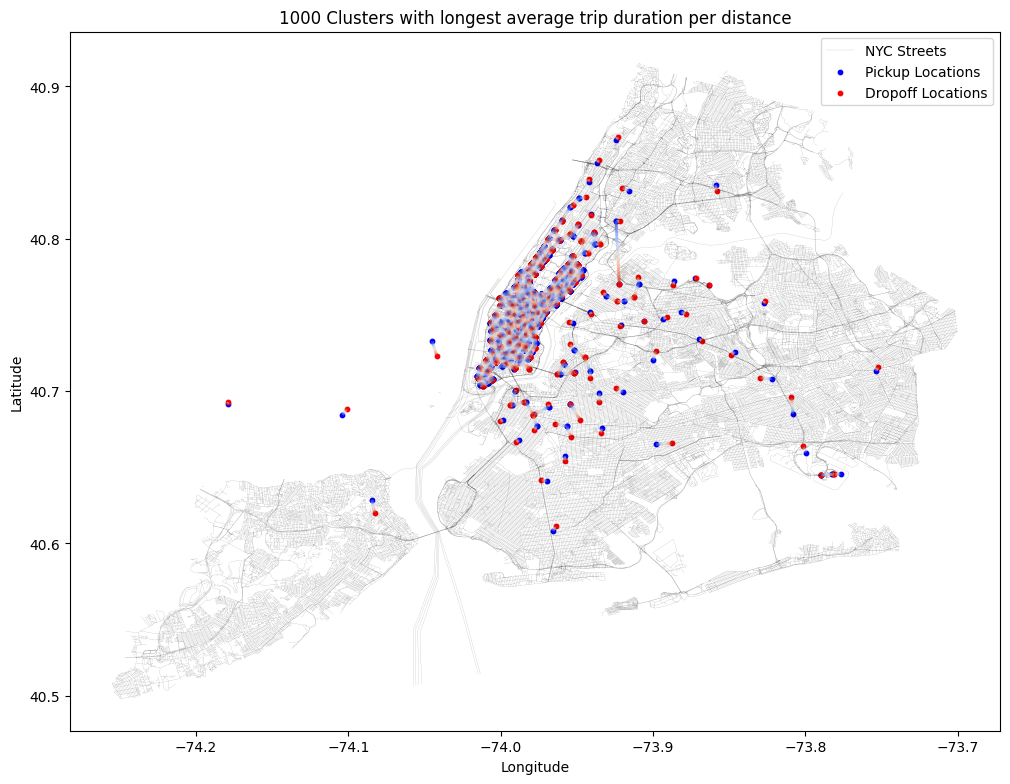

In [36]:



# plot the GeoDataFrame
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

# plot the GeoDataFrame on the current ax
nyc_gdf.plot(ax=ax, linewidth=0.1, edgecolor='black', alpha=0.5, label="NYC Streets")

#nyc_gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(pickup_longitudes, pickup_latitudes, c='blue', alpha=1.0, s=10, label="Pickup Locations")
plt.scatter(dropoff_longitudes, dropoff_latitudes, c='red', alpha=1.0, s=10, label="Dropoff Locations")
    
for plong, plat, dlong, dlat in zip(pickup_longitudes, pickup_latitudes, dropoff_longitudes, dropoff_latitudes):
    x = np.linspace(plong, dlong, 100)
    y = np.linspace(plat, dlat, 100)
    cols = np.linspace(0, 1, 100)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                              
    lc = LineCollection(segments, cmap='coolwarm')
    lc.set_array(cols)
    lc.set_linewidth(2)
    #lc.set_alpha(0.2)
    ax.add_collection(lc)
    
    #plt.plot([plong, dlong], [plat, dlat], color='black', alpha=0.2)
plt.title(f"{n} Clusters with longest average trip duration per distance")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




In [ ]:
best_traffic = cluster_dist.iloc[-n:, :]

pickup_longitudes = best_traffic['pickup_longitude'].values
pickup_latitudes = best_traffic['pickup_latitude'].values
dropoff_longitudes = best_traffic['dropoff_longitude'].values
dropoff_latitudes = best_traffic['dropoff_latitude'].values




# plot the GeoDataFrame
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

# plot the GeoDataFrame on the current ax
nyc_gdf.plot(ax=ax, linewidth=0.1, edgecolor='black', alpha=0.5, label="NYC Streets")

#nyc_gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(pickup_longitudes, pickup_latitudes, c='blue', alpha=1.0, s=10, label="Pickup Locations")
plt.scatter(dropoff_longitudes, dropoff_latitudes, c='red', alpha=1.0, s=10, label="Dropoff Locations")
    
for plong, plat, dlong, dlat in zip(pickup_longitudes, pickup_latitudes, dropoff_longitudes, dropoff_latitudes):
    x = np.linspace(plong, dlong, 100)
    y = np.linspace(plat, dlat, 100)
    cols = np.linspace(0, 1, 100)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                              
    lc = LineCollection(segments, cmap='coolwarm')
    lc.set_array(cols)
    #lc.set_linewidth(50)
    #lc.set_alpha(0.2)
    ax.add_collection(lc)
    
    #plt.plot([plong, dlong], [plat, dlat], color='black', alpha=0.2)
plt.title(f"{n} Clusters with shortest average trip duration per distance")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

x    = np.linspace(0,1, 100)
y    = np.linspace(0,1, 100)
cols = np.linspace(0,1,len(x))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, ax = plt.subplots()
lc = LineCollection(segments, cmap='coolwarm')
lc.set_array(cols)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line,ax=ax)
plt.show()
plt.clf()

fig, ax = plt.subplots()

plongs = np.random.random(10)
plats = np.random.random(10)
dlongs = np.random.random(10)
dlats = np.random.random(10)

plt.scatter(plongs, plats, c='blue', alpha=1.0, s=10, label="Pickup Locations")
plt.scatter(dlongs, dlats, c='red', alpha=1.0, s=10, label="Dropoff Locations")

for plong, plat, dlong, dlat in zip(plongs, plats, dlongs, dlats):
    x = np.linspace(plong, dlong, 100)
    y = np.linspace(plat, dlat, 100)
    cols = np.linspace(0, 1, 100)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                              
    lc = LineCollection(segments, cmap='coolwarm')
    lc.set_array(cols)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    

plt.show()

In [ ]:
display(group_durations.sort_values(by='avg_cluster_duration', ascending=True))

# histograp of group_durations['avg_cluster_duration']
plt.figure(figsize=(12, 8))
plt.hist(group_durations['avg_cluster_duration'], bins=100)
plt.xlabel("Average Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Average Duration from Cluster to Cluster")
plt.show()


In [ ]:
# show a heatmap of group_durations where X-axis is pickup_200_cluster and Y-axis is dropoff_200_cluster
# and the heat values is the average duration from cluster to cluster
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = group_durations.pivot(index='pickup_200_cluster', columns='dropoff_200_cluster', values='avg_cluster_duration')
plt.figure(figsize=(20, 20))
sns.heatmap(pivot_df, cmap='viridis')
plt.title("Average Duration from Cluster to Cluster")
plt.xlabel("Dropoff Cluster")
plt.ylabel("Pickup Cluster")
plt.show()


In [ ]:
arr = pd.Series(np.array([1,2,np.nan,3,np.nan]))
print(np.mean(arr))

In [ ]:
np.random.seed(42)
test = pd.DataFrame({
    'A':[1,2,1,2,1,2,1,2,1,2,1,2],
    'B':[1,2,3,1,2,3,1,2,3,1,2,3],
    'C': np.random.random(12),
    'D': np.arange(12)
})
display(test)

thingy = (test.groupby(['A', 'B'])['C']
          .mean()
          .reset_index()
          .rename(columns={'C': 'mean'}))
display(thingy)


In [ ]:
(0.598658+0.708073)/2

### end load NYC roads as geopandas

In [ ]:
def f(x): return -1.7*x**3 + 4.2*x**2 + 3.1*x + 2.3

n = 100
xs = np.linspace(-10, 10, n)
xs_noise = np.linspace(-10, 10, n) + np.random.normal(0, 1, n)
ys = f(xs)
ys_noise = f(xs_noise)
ys_noise += np.random.normal(0, 300, n)

plt.scatter(xs_noise, ys_noise)
#plt.plot(xs, ys, color='red')

X = np.hstack([xs_noise.reshape((-1,1))**j for j in range(0, 4)])

b_hat = np.linalg.inv(X.T @ X) @ X.T @ ys_noise
def approx_f(x, b_hat): return b_hat[0] + b_hat[1]*x + b_hat[2]*x**2 + b_hat[3]*x**3

sortation = np.argsort(xs_noise)
xs_noise = xs_noise[sortation]
ys_noise = ys_noise[sortation]
approx_y = approx_f(xs_noise, b_hat)



plt.plot(xs_noise, approx_f(xs_noise, b_hat), color='green')
plt.show()

print(X)

In [ ]:
centerline_df = pd.read_csv(f"{data_path}/Centerline.csv")
display(centerline_df)

# testing data loading

In [ ]:
train = get_train_data()
test = get_test_data()
X, y = get_X_y()

display(train)
display(test)
display(X)
display(y)

In [ ]:
print(X['vendor_id'].unique())

# figuring out data cleaning

In [ ]:
import pandas as pd
from config import data_path

train = pd.read_csv(f'{data_path}/train.csv')
test = pd.read_csv(f'{data_path}/test.csv')

cols_to_drop = ['id', 'store_and_fwd_flag', 'dropoff_datetime']

train_cols_to_drop = [c for c in train.columns if c in cols_to_drop]
train_cleaned = train.drop(columns=train_cols_to_drop)

test_cols_to_drop = [c for c in test.columns if c in cols_to_drop]
test_cleaned = test.drop(columns=test_cols_to_drop)


display(train_cleaned)
display(test_cleaned)

# trying nyc on XGBoost vanilla

In [ ]:
data_path = "/home/jeffx/ACME/senior/vol3/_Homework/data/nyc-taxi-trip-duration/train.csv"
nyc_data = pd.read_csv(data_path)
rel_cols = [
    'pickup_datetime', 'dropoff_datetime', 'passenger_count', 
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
    'dropoff_latitude', 'trip_duration']
data = nyc_data[rel_cols].copy()
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime']).astype('int64') // 10**9
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime']).astype('int64') // 10**9
# scale the pickup and dropoff datetimes with min-max scaling
data['pickup_datetime'] = (data['pickup_datetime'] - data['pickup_datetime'].min()) / (data['pickup_datetime'].max() - data['pickup_datetime'].min())
data['dropoff_datetime'] = (data['dropoff_datetime'] - data['dropoff_datetime'].min()) / (data['dropoff_datetime'].max() - data['dropoff_datetime'].min())

X = data.drop('trip_duration', axis=1).copy().values
y = data['trip_duration'].copy().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regres = xgb.XGBRegressor()
xgb_regres.fit(X_train, y_train)
y_pred = xgb_regres.predict(X_test)
y_pred = y_pred.astype(int)
y_pred[y_pred < 0] = 0

print(y_pred[y_pred < 0])

print(np.sum(y_pred >= 0), len(y_pred))

from sklearn.metrics import mean_squared_error
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

# compute the Root Mean Squared Logarithmic Error
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y_pred))))
print("RMSLE: ", rmsle(y_test, y_pred))

# predict type of exercise

<h1>Question 5.18</h1>

Apply a random forest regressor or classifier to your final project dataset.

(i) Optimize the choice of hyperparameters, including <code>n_estimators</code>, <code>max_depth</code> and <code>max_features</code>.

(ii) Compare the performance of the random forest to the performance of other types of models on this dataset.

(iii) If appropriate for this dataset, identify the three most and least important features. If this is not appropriate to do for this dataset, explain why it is not.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_california_housing, load_digits
from sklearn.model_selection import train_test_split
from seaborn import load_dataset as sns_load_dataset
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
import json
import xgboost as xgb

data_path = "/home/jeffx/ACME/WearableHealthPredictor/data"

np.set_printoptions(precision=5, suppress=True)
pd.set_option("display.precision", 15)
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})
pd.set_option('display.float_format', lambda x: "{0:0.7f}".format(x))
pd.set_option('display.max_columns', None)

def movecol(df, cols_to_move=[], ref_col='', place='After'):
    """Moves columns around in a dtaframe
    Examples:
    1)
        df cols ['A', 'B', 'C', 'D', 'X', 'Y', 'Z']
        movecol(df, cols_to_move=['X', 'Y', 'Z'], ref_col='B', place='After')
        df cols ['A', 'B', 'X', 'Y', 'Z', 'C', 'D']]
        
    2)
        df cols ['A', 'B', 'C', 'D', 'X', 'Y', 'Z']
        movecol(df, cols_to_move=['X', 'Y', 'Z'], ref_col='A', place='Before')
        df cols ['X', 'Y', 'Z', 'A', 'B', 'C', 'D']
    """
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    return(df[seg1 + seg2 + seg3])

In [ ]:
# load in the csv and select only the relevant columns
df_exercise = pd.read_csv(f"{data_path}/activity_environment_data.csv")
rel_cols = [
    'Steps', 'Calories_Burned', 'Distance_Covered', 
    'Exercise_Duration', 'Exercise_Intensity', 
    'Ambient_Temperature', 'Altitude', 'UV_Exposure'] + ['Exercise_Type']
df_exercise = df_exercise[rel_cols]

# convert exercise intensity to a numeric value
df_exercise['Exercise_Intensity'] = df_exercise['Exercise_Intensity'].fillna('None')
df_exercise['Exercise_Intensity'] = df_exercise['Exercise_Intensity'].map(
    {'None': 0, 'Low':1, 'Moderate':2, 'High':3}
)
display(df_exercise)

for exercise_type, frame in df_exercise.groupby('Exercise_Type'):
    print(exercise_type)
    display(frame.describe())

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your data (replace 'your_data.csv' with the actual path to your data)
data = df_exercise

# Select the features you want to use for clustering
features = data[['Steps', 'Calories_Burned', 'Distance_Covered', 'Exercise_Duration',
                 'Exercise_Intensity', 'Ambient_Temperature', 'Altitude', 'UV_Exposure']].copy().values

# Standardize the data (important for K-Means)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3)

# Fit the model to your data
kmeans.fit(scaled_features)

# Add cluster labels to your DataFrame
data['Cluster'] = kmeans.labels_

# View the results, e.g., the count of data points in each cluster
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)
print(pca_data.shape)

# You can also plot the clusters if you want to visualize the results
plt.scatter(pca_data[:,0], pca_data[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.1)
plt.show()


In [ ]:
# load in each of the dataframes
data_path = "/home/jeffx/ACME/WearableHealthPredictor/data"
df = pd.read_csv(f"{data_path}/health_data_clean.csv")

# merge the Exercise_Type columns together to get it as a predicted column
all_exercise_type_cols = ["Exercise_Type_None",	"Exercise_Type_Running", "Exercise_Type_Strength Training", "Exercise_Type_Yoga"]
exercise_type_cols = ["Exercise_Type_Running", "Exercise_Type_Strength Training", "Exercise_Type_Yoga"]
for i, col in enumerate(exercise_type_cols):
    df[col] = df[col] * (i + 1)
df["Exercise_Type"] = df[exercise_type_cols].sum(axis=1) - 1
df = df.drop(columns=all_exercise_type_cols)
df = df.loc[df['Exercise_Type'] != -1, :]

# only consider the relevent columns
rel_cols = [
    'Steps', 'Calories_Burned', 'Distance_Covered', 
    'Exercise_Duration', 'Exercise_Intensity', 
    'Ambient_Temperature', 'Altitude', 'UV_Exposure']

df = df[rel_cols + ["Exercise_Type"]]

# split the data into X and y for train and test
X_df = df.drop(columns=["Exercise_Type"])
features = X_df.columns.tolist()
X = X_df.copy().values

y = df["Exercise_Type"].copy().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
display(df)

for exercise_type, frame in df.groupby("Exercise_Type"):
    print(exercise_type)
    display(frame.describe())

### train optimal RandomForestClassifier

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 3, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}

# Create a GridSearchCV object and get the optimal parameters and best score
rf = RandomForestClassifier(warm_start=False)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1).fit(X_train, y_train)

# get the best params and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# save the best_params and best_accuracy so I don't have to rerun the GridSearchCV again
import json
with open("best_params.json", "w") as f:
    obj = {
        'best_accuracy': float(round(best_accuracy, 5)), 
        'best_params':best_params
    }
    json.dump(obj, f)

In [ ]:
# load the best params and accuracy
with open("best_params.json") as file:
    obj = json.load(file)
    best_accuracy = obj['best_accuracy']
    best_params = obj['best_params']

# train a new model using the optimal parameters
rf_optimal = RandomForestClassifier(**best_params, warm_start=False)
rf_optimal.fit(X_train, y_train)
rf_predictions = rf_optimal.predict(X_test)
rf_accuracy = rf_optimal.score(X_test, y_test)

# select the top 5 features
feature_importance = rf_optimal.feature_importances_
features_sorted = sorted(list(zip(features, feature_importance)), key=lambda x: x[1], reverse=True)
top_5_features = features_sorted[:5]
top_features, top_feature_scores = map(list, zip(*top_5_features))

# print out the best parameters and the Accuracy
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("Top 5 Features:", top_features)
print("Top 5 Feature Scores:", top_feature_scores)

### train an XGBoost Classifier

In [ ]:
# train and predict with a default XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# get the accuracy and feature importance
xgb_accuracy = xgb_model.score(X_test, y_test)
xgb_feature_importance = xgb_model.feature_importances_
xgb_features_sorted = sorted(list(zip(features, xgb_feature_importance)), key=lambda x: x[1], reverse=True)
xgb_top_5_features = xgb_features_sorted[:5]
xgb_top_features, xgb_top_feature_scores = map(list, zip(*xgb_top_5_features))

# print out the accuracy and top 5 features
print("XGB Accuracy:", xgb_accuracy)
print("XGB Top 5 Features:", xgb_top_features)
print("XGB Top 5 Feature Scores:", xgb_top_feature_scores)

### train a decision tree classifier

In [ ]:
# train and predict with a default DecisionTree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# get the accuracy and feature importance
dt_accuracy = dt_model.score(X_test, y_test)
dt_feature_importance = dt_model.feature_importances_
dt_features_sorted = sorted(list(zip(features, dt_feature_importance)), key=lambda x: x[1], reverse=True)
dt_top_5_features = dt_features_sorted[:5]
dt_top_features, dt_top_feature_scores = map(list, zip(*dt_top_5_features))

# print out the accuracy and top 5 features
print("DT Accuracy:", dt_accuracy)
print("DT Top 5 Features:", dt_top_features)
print("DT Top 5 Feature Scores:", dt_top_feature_scores)

### analysis

In [ ]:
# display an accuracy table for the 3 models
accuracy_df = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost', 'DecisionTree'],
    'Accuracy': [rf_accuracy, xgb_accuracy, dt_accuracy],
    'Optimized': [True, False, False]
})
display(accuracy_df)

In [ ]:
# plot each of the ROC curves
def plot_roc_auc(fpr, tpr, roc_auc, classifier, data_name):
    """takes in the false-positive-rate, the true-positive-rate and the
    area-under-the-curve, the name of the classifier, and the name of the dataset
    and plots the ROC curver with the AUC
    """
    plt.plot(fpr, tpr, color='yellow', lw=5, label=f"{classifier} for {data_name}")
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve, AUC={round(roc_auc, 3)}')
    plt.legend(loc='lower right')

# for each model plot the ROC curve for each class
models = [('RandomForest', rf_optimal), ('XGBoost', xgb_model), ('DecisionTree', dt_model)]
classes = ["Running", "Strength Training", "Yoga"]

for i, (model_name, model) in enumerate(models):
    
    probs = model.predict_proba(X_test)
    print(probs)
    
    # for each class
    for j, probs_col in enumerate(probs.T):
        curr_class = classes[j]
        
        # select only the rows that are the current class
        mask = y_test == j
        y_test_curr_class = np.zeros(len(y_test))
        y_test_curr_class[mask] = 1
        
        # get the ROC curve and the AUC (Area Under the Curve) values
        fpr, tpr, thresholds = roc_curve(y_test_curr_class, probs_col)
        roc_auc = auc(fpr, tpr)
        plt.subplot(3, 4, i*4 + j+1)
        plot_roc_auc(fpr, tpr, roc_auc, model_name, curr_class)
    
# show the final plot
plt.gcf().set_size_inches(20,15)
plt.show()